In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time

import sys
sys.path.insert(0, '../')

In [3]:
from libra import ObservationArchive, mask_simultaneous_transits, transit_model, trappist1

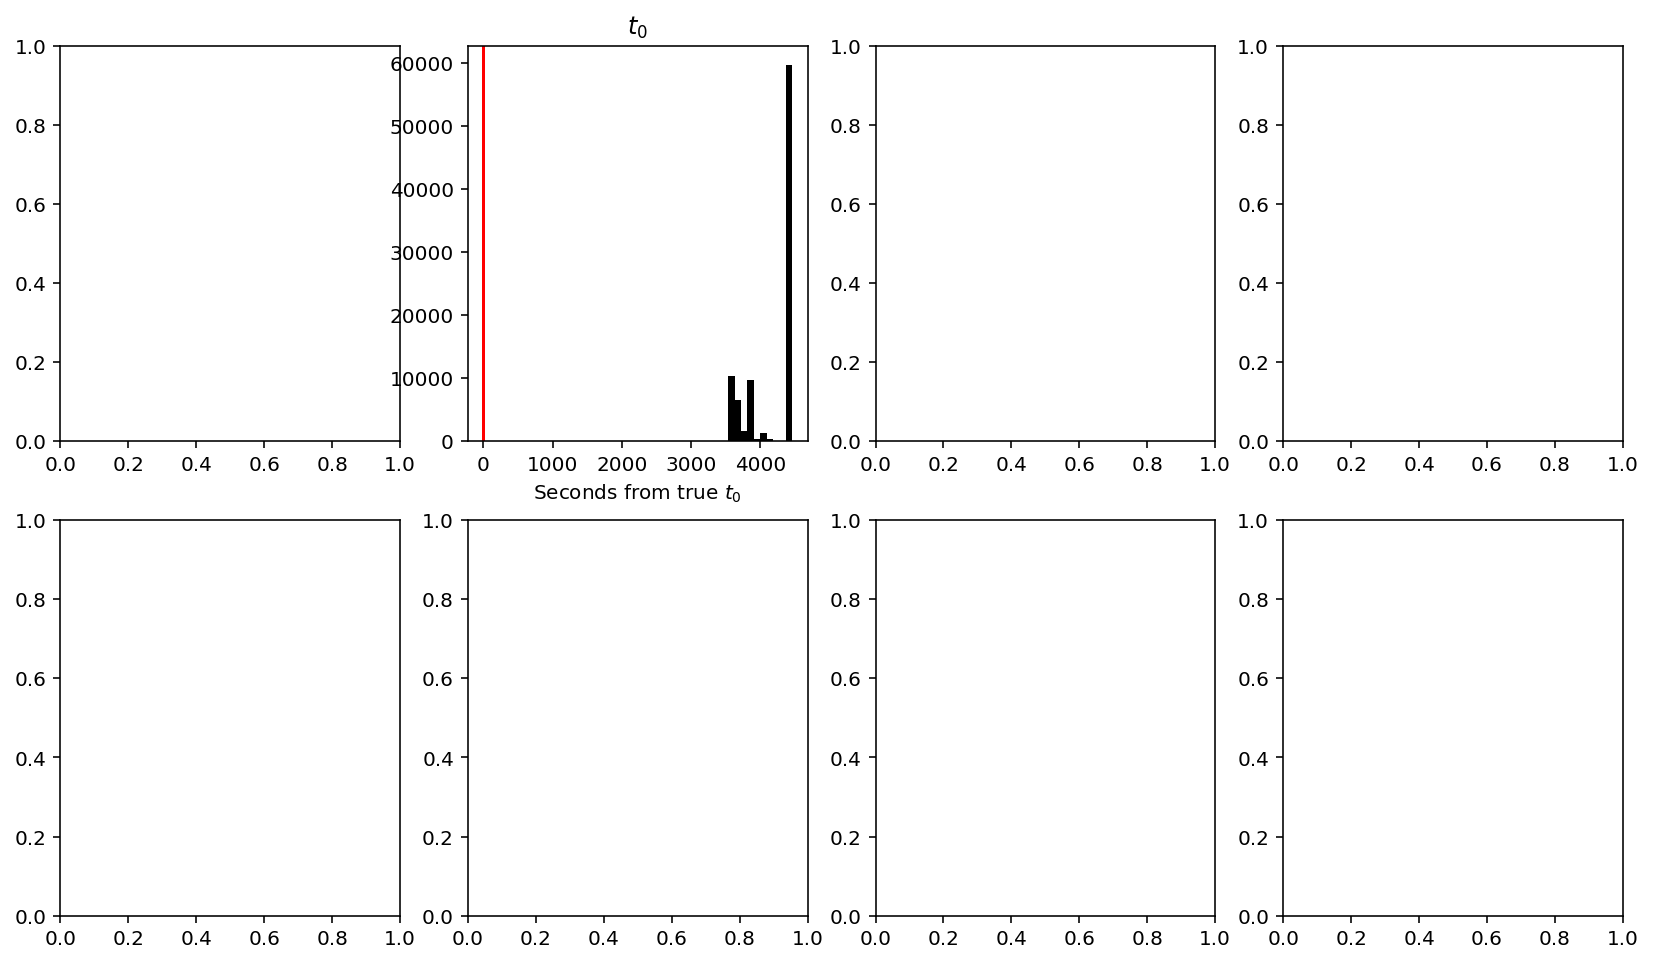

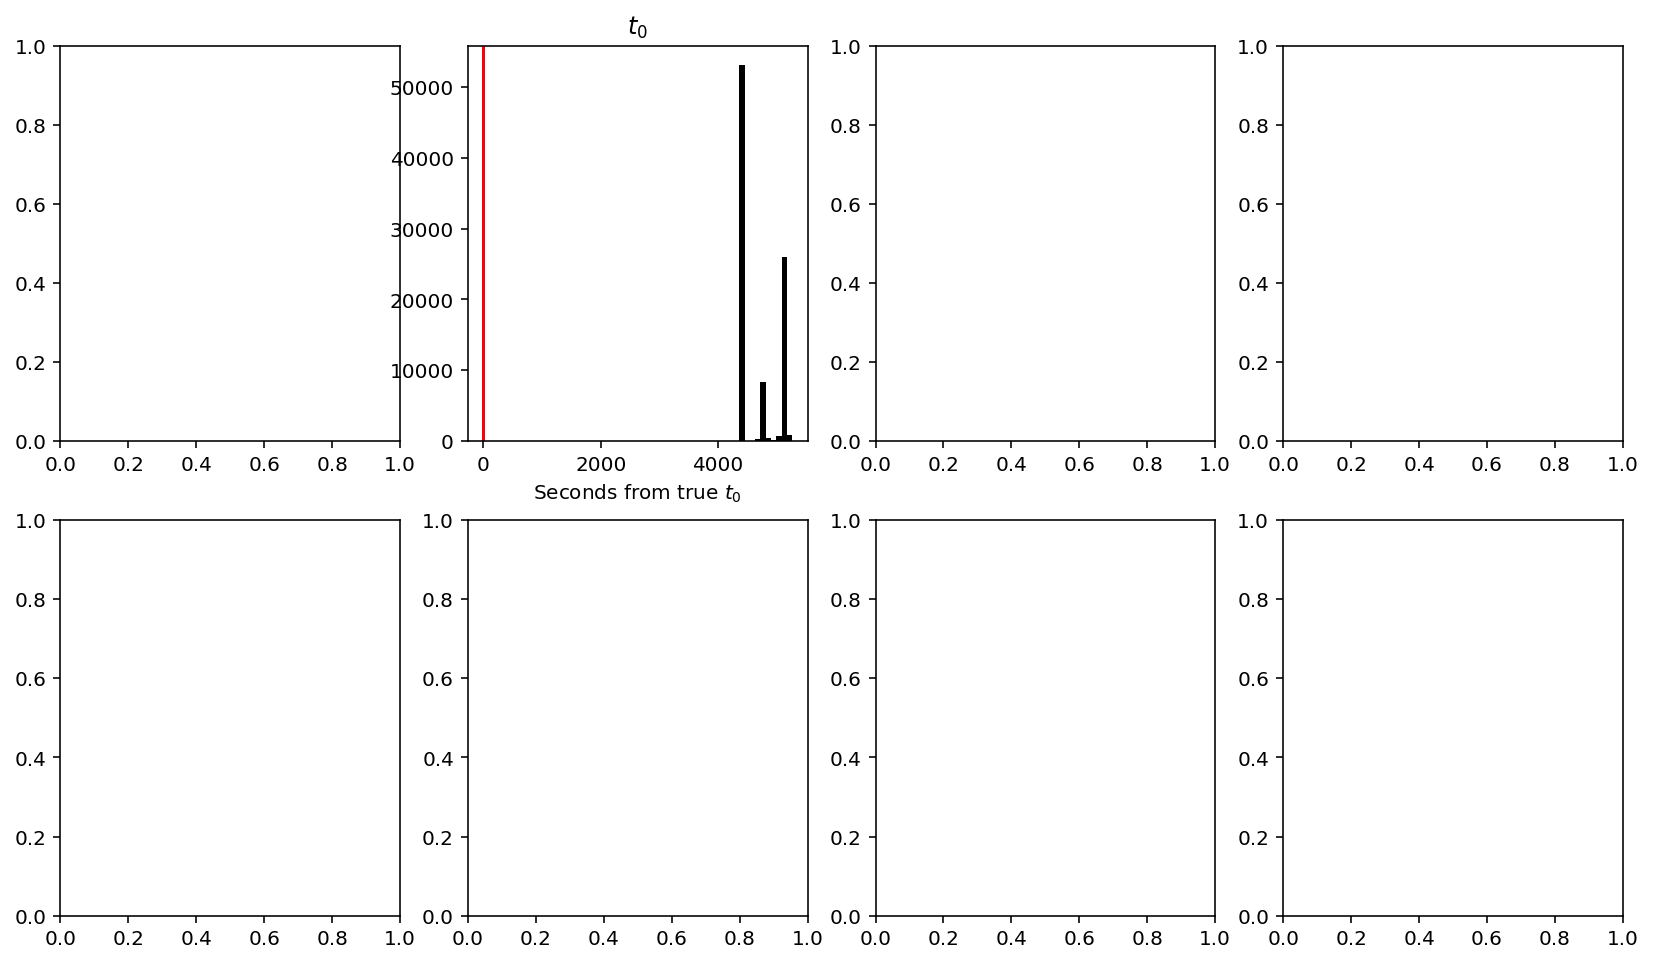

In [5]:
import celerite
from celerite import terms
from celerite.modeling import Model
from copy import deepcopy
from interpacf import interpolated_acf

#run_name = 'trappist1_bright2'
#run_name = 'trappist1_microflares'
#run_name = 'trappist1_halftransit'
planet = 'b'

original_params = trappist1(planet)

class MeanModel(Model):
    parameter_names = ['amp', 'depth', 't0']

    def get_value(self, t):
        params = deepcopy(original_params)
        params.rp = self.depth**0.5
        params.t0 = self.t0
        times = t - t.mean()
        return self.amp * transit_model(t, params)


with ObservationArchive(run_name + "_" + planet, 'r') as obs:
    for obs_planet in getattr(obs, planet)[:2]:
#         try: 
        mask = mask_simultaneous_transits(obs_planet.times, planet)
#             not_during_flares = np.abs(np.max(obs_planet.flares, axis=1) - 1) < 1e-3
#             mask &= not_during_flares

        obs_time = obs_planet.times[mask]
        obs_flux = np.sum(obs_planet.spectra[mask], axis=1)
        obs_err = np.sqrt(obs_flux)

        # GP
        initp_dict = dict(amp=np.median(obs_flux), depth=original_params.rp**2, 
                          t0=original_params.t0)#, c0=0, c1=0)

        parameter_bounds = dict(amp=[np.min(obs_flux), np.max(obs_flux)], 
                                depth=[0.5 * original_params.rp**2, 1.5 * original_params.rp**2],
                                t0=[original_params.t0 - 0.5, original_params.t0 + 0.5])

        mean_model = MeanModel(**initp_dict, bounds=parameter_bounds)

        Q = 1.0 / np.sqrt(2.0)
        log_w0 = np.log(2*np.pi/(8/24))
        log_S0 = 0

        log_cadence_min = None # np.log(2*np.pi/(2./24))
        log_cadence_max = np.log(2*np.pi/(0.25/24))

        kernel = terms.SHOTerm(log_S0=log_S0, log_Q=np.log(Q),
                               log_omega0=log_w0)
        #
        kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

        gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)
        bestp = obs_planet.samples_median
        gp.set_parameter_vector(bestp)
        gp.compute(obs_time, obs_err)
#         try: 

        skip = 1
        mu, var = gp.predict(obs_flux, obs_time[::skip], return_var=True)
        std = np.sqrt(var)

#             samples = np.vstack([obs_planet.samples_amp, obs_planet.samples_depth, 
#                                  obs_planet.samples_t0, obs_planet.samples_log_omega0, obs_planet.samples_log_S0])

#             from corner import corner
#             corner(samples.T, labels=['amp', 'depth', 't0', 'log_omega0', 'log_S0'])
#             plt.show()

        transit_params = trappist1(planet)
        transit_params.rp = np.sqrt(np.median(obs_planet.samples_depth))
        transit_params.t0 = np.median(obs_planet.samples_t0)
        amp = np.median(obs_planet.samples_amp)
        best_transit_model = amp * transit_model(obs_time, transit_params)

        transitless_gp_mean = mu - best_transit_model
        transitless_obs_flux = obs_flux - best_transit_model

        fig, ax = plt.subplots(2, 4, figsize=(14, 8))
#         ax[0, 0].errorbar(obs_time, obs_flux, obs_err, fmt='.', color='k', ecolor='silver', ms=2, alpha=0.5)
#         ax[0, 0].plot(obs_time[::skip], mu, 'r', zorder=10)
#         ax[0, 0].fill_between(obs_time[::skip], mu-std, mu+std, color='r', alpha=0.5, zorder=10)
#         ax[0, 0].set_title(Time(obs_time.min(), format='jd').datetime.date())
#         ax[0, 0].set_ylabel('NIRSpec Counts')
#         ax[0, 0].set_xlabel('Time [d]')

#         ax[1, 0].errorbar(obs_time, obs_flux - best_transit_model,  obs_err, fmt='.', 
#                           color='k', ecolor='silver', ms=2, alpha=0.5, label='transit residuals')
#         model_residual = amp * (obs_planet.fluxes[mask] + obs_planet.spitzer_var[mask] - 2)
#         model_residual -= np.median(model_residual)
#         ax[1, 0].plot(obs_time, model_residual, 'r', lw=2, zorder=10, label='microvar + spots')

#         ax[1, 0].plot(obs_time, transitless_gp_mean, color='DodgerBlue', label='GP-transit', zorder=15)
#         ax[1, 0].legend()
#         nparams = 5
        #samples_t0 = obs_planet.samples_t0.reshape((len(obs_planet.samples_t0)//nparams, nparams))
#         samples_t0 = obs_planet.samples_t0.reshape((nparams, len(obs_planet.samples_t0)//nparams))

#         for chain in samples_t0:
#             lag, acf = interpolated_acf(np.arange(len(chain)), 
#                                         chain - np.median(chain))
#             ax[1, 1].plot(lag, acf/acf.max())
#         ax[1, 1].set_title('$t_0$ chains ACF')


#         lag, acf = interpolated_acf(obs_time, transitless_obs_flux - np.median(transitless_obs_flux))
#         ax[1, 3].plot(lag, acf/np.percentile(acf, 98), label='(Obs - transit) ACF')
#         #ax[1, 3].set_title('(Obs. - transit) ACF')

#         lag, acf = interpolated_acf(obs_time, transitless_gp_mean - np.median(transitless_gp_mean))
#         ax[1, 3].plot(lag, acf/acf.max(), ls='--', lw=2, label='(GP - transit) ACF')
#         ax[1, 3].legend()
#         #ax[1, 3].set_title('(GP - transit) ACF')


#         samples_depth = obs_planet.samples_depth.reshape((nparams, len(obs_planet.samples_depth)//nparams))

#         for chain in samples_depth:
#             lag, acf = interpolated_acf(np.arange(len(chain)), 
#                                         chain - np.median(chain))
#             ax[1, 2].plot(lag, acf/acf.max())
#         ax[1, 2].set_title('Depth chains ACF')


        answer_key = dict(obs_planet.attrs)
        mid_transit_answer = answer_key['t0']
        n_transits = np.round((obs_planet.samples_t0.mean() - mid_transit_answer) / trappist1(planet).per)
        mid_transit_answer_translated = mid_transit_answer + trappist1(planet).per * n_transits        

        ax[0, 1].hist((obs_planet.samples_t0 - mid_transit_answer_translated)*24*60*60, color='k')
        ax[0, 1].axvline(mid_transit_answer_translated - mid_transit_answer_translated, color='r')
        ax[0, 1].set_title('$t_0$')
        ax[0, 1].set_xlabel('Seconds from true $t_0$')

#         ax[0, 2].set_title('Depth')
#         ax[0, 2].hist(obs_planet.samples_depth, color='k')
#         ax[0, 2].axvline(trappist1(planet).rp**2, color='r')
#         plt.setp(ax[0, 2].get_xticklabels(), rotation=30, ha='right')

#         ax[0, 3].plot(obs_time, obs_planet.fluxes[mask], label='flux')
#         ax[0, 3].plot(obs_time, obs_planet.spitzer_var[mask], label='microvar')
#         ax[0, 3].plot(obs_time, np.max(obs_planet.flares, axis=1)[mask], label='flares')

#         ax[0, 3].legend()
#         fig.tight_layout()
        plt.show()
#         except (OSError, ValueError, KeyError):
#             pass

In [ ]:
import celerite
from celerite import terms
from celerite.modeling import Model
from copy import deepcopy
from interpacf import interpolated_acf

run_name = 'trappist1_bright2'
#run_name = 'trappist1_microflares'
#run_name = 'trappist1_halftransit'
planet = 'h'

original_params = trappist1(planet)


    
with ObservationArchive(run_name + "_" + planet, 'r') as obs:
    print(obs.h[0])
    plt.hist(obs.h[0].samples_t0)